# What do lightcurves look like in the calexps versus the difference images?

## February 2020 Analysis Sprint

For observations of transients, we can measure the accuracy of the calibration by looking at the "lightcurves" of static objects. There are two questions that we wish to answer: first, how do the magnitudes of stars in individual exposures compare to the magnitudes of the stars in the coadded image catalogs; second, what do we measure using forced photometry at the position of the stars in the difference imaging?

If the calibration could be done perfectly, we would expect to measure the same magnitude for a given star in all calexps and in the coadded image. Similarly, if the subtraction was perfect, we would measure zero flux at the star position in the difference images (assuming no true transient was present nearby). In reality, we aim to have results consistent with the ideal scenario to within error bars. 

We will check this with difference imaging produced in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/ap_pipe_I`, with the forced photometry in `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_src_dir` for the calexps and `/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim` for the difference images. For this preliminary analysis, we just look at one patch in COSMOS in the HSC-I band.

In [34]:
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import lsst.geom as geom
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import scipy.stats
import os.path

In [3]:
# Rerun with forced photometry on calexps
butler = Butler('/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_src_dir')

In [4]:
# Rerun with forced photometry on diffims
butler_diffim = Butler('/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim')

In [5]:
# Get the coadded image
coadd = butler.get('deepCoadd', tract=9813, patch='4,3', filter='HSC-I')
psf = coadd.getPsf()
coaddWcs = coadd.getWcs()

### Get the forced photometry measurements in the coadd:

In [293]:
# Get the catalog of measurements using the position in I
measurements = butler.get('deepCoadd_ref', tract=9813, patch='4,3', filter='HSC-I')
refCatalog = measurements.asAstropy().to_pandas()
# Only 20% of the objects
refCatalog = refCatalog[refCatalog['detect_isPrimary']][::5]

In [294]:
# Get the catalog of measurements using the best position from the combined filter catalogs
measurements_meas = butler.get('deepCoadd_meas', tract=9813, patch='4,3', filter='HSC-I')
measCatalog= measurements_meas.asAstropy().to_pandas()
measCatalog = measCatalog[measCatalog['detect_isPrimary']][::5]

In [10]:
# Inputs to the coadd
inputs = coadd.getInfo().getCoaddInputs()

In [11]:
lenCalexp = psf.getComponentCount()

### Get the forced photometry measurements in individual calexps and diffims:

In [295]:
calexp_flux = np.zeros((len(refCatalog), lenCalexp))
calexp_fluxerr = np.zeros((len(refCatalog), lenCalexp))

diff_flux = np.zeros((len(refCatalog), lenCalexp))
diff_fluxerr = np.zeros((len(refCatalog), lenCalexp))

diff_flux_lax = np.zeros((len(refCatalog), lenCalexp))
diff_fluxerr_lax = np.zeros((len(refCatalog), lenCalexp))

In [296]:
for i in range(lenCalexp):
    ccd = int(inputs.ccds['ccd'][i])
    visit = int(inputs.ccds['visit'][i])
    calexp = butler.get('forced_src', tract=9813, filter='HSC-I', ccd=ccd, visit=visit) 
    calexp_diff = butler_diffim.get('forced_diaSrc', tract=9813, filter='HSC-I', ccd=ccd, visit=visit)
    calexp_cat = calexp.asAstropy().to_pandas()
    calexp_ind = (calexp_cat['base_PixelFlags_flag_bad'] | calexp_cat['base_PixelFlags_flag_crCenter']
                  | calexp_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                  calexp_cat['base_PixelFlags_flag_saturatedCenter'] | 
                  calexp_cat['base_PixelFlags_flag_suspectCenter'])
    calexp_cat = calexp_cat[~calexp_ind]
    diff_cat = calexp_diff.asAstropy().to_pandas()
    diff_ind = (diff_cat['base_PixelFlags_flag_bad'] | diff_cat['base_PixelFlags_flag_crCenter']
                | diff_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                diff_cat['base_PixelFlags_flag_saturatedCenter'] | 
                diff_cat['base_PixelFlags_flag_suspectCenter'])
    diff_ind_lax = (diff_cat['base_PixelFlags_flag_bad'] | diff_cat['base_PixelFlags_flag_crCenter']
                | diff_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                diff_cat['base_PixelFlags_flag_saturatedCenter'])
    diff_cat = diff_cat[~diff_ind]
    diff_cat_lax = diff_cat[~diff_ind_lax]
    calexp_merge = pd.merge(refCatalog, calexp_cat, left_on='id', right_on='objectId', how='left')
    diff_merge = pd.merge(refCatalog, diff_cat, left_on='id', right_on='objectId', how='left')
    diff_merge_lax = pd.merge(refCatalog, diff_cat_lax, left_on='id', right_on='objectId', how='left')
    calexp_flux[:, i] = calexp_merge['base_PsfFlux_instFlux_y'] * calexp_merge['base_LocalPhotoCalib']
    calexp_fluxerr[:, i] = calexp_merge['base_PsfFlux_instFluxErr_y'] * calexp_merge['base_LocalPhotoCalib']
    diff_flux[:, i] = diff_merge['base_PsfFlux_instFlux_y'] * diff_merge['base_LocalPhotoCalib']
    diff_fluxerr[:, i] = diff_merge['base_PsfFlux_instFluxErr_y'] * diff_merge['base_LocalPhotoCalib']
    diff_flux_lax[:, i] = diff_merge_lax['base_PsfFlux_instFlux_y'] * diff_merge_lax['base_LocalPhotoCalib']
    diff_fluxerr_lax[:, i] = diff_merge_lax['base_PsfFlux_instFluxErr_y'] * diff_merge_lax['base_LocalPhotoCalib']

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [297]:
calexp_flux_meas = np.zeros((len(measCatalog), lenCalexp))
calexp_fluxerr_meas = np.zeros((len(measCatalog), lenCalexp))

diff_flux_meas = np.zeros((len(measCatalog), lenCalexp))
diff_fluxerr_meas = np.zeros((len(measCatalog), lenCalexp))

diff_flux_lax_meas = np.zeros((len(measCatalog), lenCalexp))
diff_fluxerr_lax_meas = np.zeros((len(measCatalog), lenCalexp))
for i in range(lenCalexp):
    ccd = int(inputs.ccds['ccd'][i])
    visit = int(inputs.ccds['visit'][i])
    calexp = butler.get('forced_src', tract=9813, filter='HSC-I', ccd=ccd, visit=visit) 
    calexp_diff = butler_diffim.get('forced_diaSrc', tract=9813, filter='HSC-I', ccd=ccd, visit=visit)
    calexp_cat = calexp.asAstropy().to_pandas()
    calexp_ind = (calexp_cat['base_PixelFlags_flag_bad'] | calexp_cat['base_PixelFlags_flag_crCenter']
                  | calexp_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                  calexp_cat['base_PixelFlags_flag_saturatedCenter'] | 
                  calexp_cat['base_PixelFlags_flag_suspectCenter'])
    calexp_cat = calexp_cat[~calexp_ind]
    diff_cat = calexp_diff.asAstropy().to_pandas()
    diff_ind = (diff_cat['base_PixelFlags_flag_bad'] | diff_cat['base_PixelFlags_flag_crCenter']
                | diff_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                diff_cat['base_PixelFlags_flag_saturatedCenter'] | 
                diff_cat['base_PixelFlags_flag_suspectCenter'])
    diff_ind_lax = (diff_cat['base_PixelFlags_flag_bad'] | diff_cat['base_PixelFlags_flag_crCenter']
                | diff_cat['base_PixelFlags_flag_interpolatedCenter'] | 
                diff_cat['base_PixelFlags_flag_saturatedCenter'])
    diff_cat = diff_cat[~diff_ind]
    diff_cat_lax = diff_cat[~diff_ind_lax]
    calexp_merge = pd.merge(measCatalog, calexp_cat, left_on='id', right_on='objectId', how='left')
    diff_merge = pd.merge(measCatalog, diff_cat, left_on='id', right_on='objectId', how='left')
    diff_merge_lax = pd.merge(measCatalog, diff_cat_lax, left_on='id', right_on='objectId', how='left')
    calexp_flux_meas[:, i] = calexp_merge['base_PsfFlux_instFlux_y'] * calexp_merge['base_LocalPhotoCalib']
    calexp_fluxerr_meas[:, i] = calexp_merge['base_PsfFlux_instFluxErr_y'] * calexp_merge['base_LocalPhotoCalib']
    diff_flux_meas[:, i] = diff_merge['base_PsfFlux_instFlux_y'] * diff_merge['base_LocalPhotoCalib']
    diff_fluxerr_meas[:, i] = diff_merge['base_PsfFlux_instFluxErr_y'] * diff_merge['base_LocalPhotoCalib']
    diff_flux_lax_meas[:, i] = diff_merge_lax['base_PsfFlux_instFlux_y'] * diff_merge_lax['base_LocalPhotoCalib']
    diff_fluxerr_lax_meas[:, i] = diff_merge_lax['base_PsfFlux_instFluxErr_y'] * diff_merge_lax['base_LocalPhotoCalib']

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Get seeing information

In [16]:
seeingDict = {}
for i in range(lenCalexp):
    ccd = int(inputs.ccds['ccd'][i])
    visit = int(inputs.ccds['visit'][i])
    seeing = {'ccd' : ccd, 'visit' : visit}
    print(i, ccd, visit)
    calexp_im = butler.get('calexp', tract=9813, filter='HSC-I', ccd=ccd, visit=visit) 
    diff_im = butler_diffim.get('deepDiff_differenceExp', tract=9813, filter='HSC-I', ccd=ccd, visit=visit)
    print(butler_diffim.get('deepDiff_differenceExp_filename', tract=9813, filter='HSC-I', ccd=ccd, visit=visit))
    calexp_seeing = calexp_im.getPsf().computeShape().getDeterminantRadius()
    diff_im_seeing = diff_im.getPsf().computeShape().getDeterminantRadius()
    seeing['calexp'] = calexp_seeing
    seeing['diffim'] = diff_im_seeing
    seeingDict[i] = seeing

0 17 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-017.fits']
1 18 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-018.fits']
2 24 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-024.fits']
3 25 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-025.fits']
4 32 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-032.fits']
5 33 19710
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01116/HSC-I/DIFFEXP-0019710-033.fits']
6 17 30484
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030484-017.fits']
7 18 30484
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff

['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030492-032.fits']
64 33 30492
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030492-033.fits']
65 40 30492
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030492-040.fits']
66 41 30492
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030492-041.fits']
67 24 30494
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030494-024.fits']
68 25 30494
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030494-025.fits']
69 32 30494
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030494-032.fits']
70 33 30494
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/012

['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01236/HSC-I/DIFFEXP-0030496-048.fits']
127 32 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-032.fits']
128 33 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-033.fits']
129 40 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-040.fits']
130 41 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-041.fits']
131 48 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-048.fits']
132 49 1246
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/00817/HSC-I/DIFFEXP-0001246-049.fits']
133 32 19682
['/datasets/hsc/repo/rerun/private/yusra/analysis-sprint/forced_diffim/deepDiff/01

### Calculate average object fluxes and magnitudes from the calexps and diffims

In [298]:
mask = np.isfinite(calexp_fluxerr)
calexp_flux_cut = calexp_flux[mask.any(axis=1)]
fluxWeights = calexp_fluxerr[mask.any(axis=1)]**-2
calexp_flux_cut[~np.isfinite(calexp_flux_cut)] = 0
fluxWeights[~np.isfinite(fluxWeights)] = 0

mask2 = np.isfinite(diff_fluxerr)
diff_flux_cut = diff_flux[mask2.any(axis=1)]
diffWeights = diff_fluxerr[mask2.any(axis=1)]**-2
diff_flux_cut[~np.isfinite(diff_flux_cut)] = 0
diffWeights[~np.isfinite(diffWeights)] = 0


In [299]:
mask_meas = np.isfinite(calexp_fluxerr_meas)
calexp_flux_cut_meas = calexp_flux_meas[mask_meas.any(axis=1)]
fluxWeights_meas = calexp_fluxerr_meas[mask_meas.any(axis=1)]**-2
calexp_flux_cut_meas[~np.isfinite(calexp_flux_cut_meas)] = 0
fluxWeights_meas[~np.isfinite(fluxWeights_meas)] = 0

mask2_meas = np.isfinite(diff_fluxerr_meas)
diff_flux_cut_meas = diff_flux_meas[mask2_meas.any(axis=1)]
diffWeights_meas = diff_fluxerr_meas[mask2_meas.any(axis=1)]**-2
diff_flux_cut_meas[~np.isfinite(diff_flux_cut_meas)] = 0
diffWeights_meas[~np.isfinite(diffWeights_meas)] = 0

In [300]:
weightedFluxAvgs = np.average(calexp_flux_cut, weights=fluxWeights, axis=1)

In [301]:
weightedFluxAvgs_meas = np.average(calexp_flux_cut_meas, weights=fluxWeights_meas, axis=1)

In [302]:
weightedDiffAvgs = np.average(diff_flux_cut, weights=diffWeights, axis=1)

In [303]:
weightedDiffAvgs_meas = np.average(diff_flux_cut_meas, weights=diffWeights_meas, axis=1)

In [304]:
meas_cut = (refCatalog['base_PsfFlux_instFlux'] * coadd.getPhotoCalib().getCalibrationMean())[mask.any(axis=1)]
meas_cut2 = (refCatalog['base_PsfFlux_instFlux'] * coadd.getPhotoCalib().getCalibrationMean())[mask2.any(axis=1)]

In [305]:
meas_cut_meas = (measCatalog['base_PsfFlux_instFlux'] * coadd.getPhotoCalib().getCalibrationMean())[mask_meas.any(axis=1)]
meas_cut2_meas = (measCatalog['base_PsfFlux_instFlux'] * coadd.getPhotoCalib().getCalibrationMean())[mask2_meas.any(axis=1)]

In [306]:
meas_mag = -2.5*np.log10(meas_cut) + 27
mags = -2.5*np.log10(calexp_flux_cut/meas_cut[:,None])
magVar = ((np.log(10)/2.5)**2) / (fluxWeights * calexp_flux_cut**2)
magWeights = magVar**-1
mags[~np.isfinite(mags)] = 0
magWeights[~np.isfinite(magWeights)] = 0

meas_mag2 = -2.5*np.log10(meas_cut2) + 27
diffMags = -2.5 * np.log10((diff_flux_cut + meas_cut2[:,None]) / meas_cut2[:,None])
diffMagVar = ((np.log(10)/2.5)**2) / (diffWeights * (diff_flux_cut + meas_cut2[:,None])**2)
diffMagWeights = diffMagVar**-1
diffMagWeights[~np.isfinite(diffMagWeights)] = 0

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero

In [308]:
meas_mag_meas = -2.5*np.log10(meas_cut_meas) + 27
mags_meas = -2.5*np.log10(calexp_flux_cut_meas/meas_cut_meas[:,None])
magVar_meas = ((np.log(10)/2.5)**2) / (fluxWeights_meas * calexp_flux_cut_meas**2)
magWeights_meas = magVar_meas**-1
mags_meas[~np.isfinite(mags_meas)] = 0
magWeights_meas[~np.isfinite(magWeights_meas)] = 0

meas_mag2_meas = -2.5*np.log10(meas_cut2_meas) + 27
diffMags_meas = -2.5 * np.log10((diff_flux_cut_meas + meas_cut2_meas[:,None]) / meas_cut2_meas[:,None])
diffMagVar_meas = ((np.log(10)/2.5)**2) / (diffWeights_meas * (diff_flux_cut_meas + meas_cut2_meas[:,None])**2)
diffMagWeights_meas = diffMagVar_meas**-1
diffMagWeights_meas[~np.isfinite(diffMagWeights_meas)] = 0

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/core/series.py:679: Run

In [309]:
weightedMagAvgs = np.average(mags, weights=magWeights, axis=1)

In [310]:
weightedMagDiffAvgs = np.average(diffMags, weights=diffMagWeights, axis=1)

In [311]:
weightedMagAvgs_meas = np.average(mags_meas, weights=magWeights_meas, axis=1)
weightedMagDiffAvgs_meas = np.average(diffMags_meas, weights=diffMagWeights_meas, axis=1)

# How does the average of the fluxes/magnitudes for an object compare with the coadd flux/magnitude in calexps and diffims?

(15, 26)

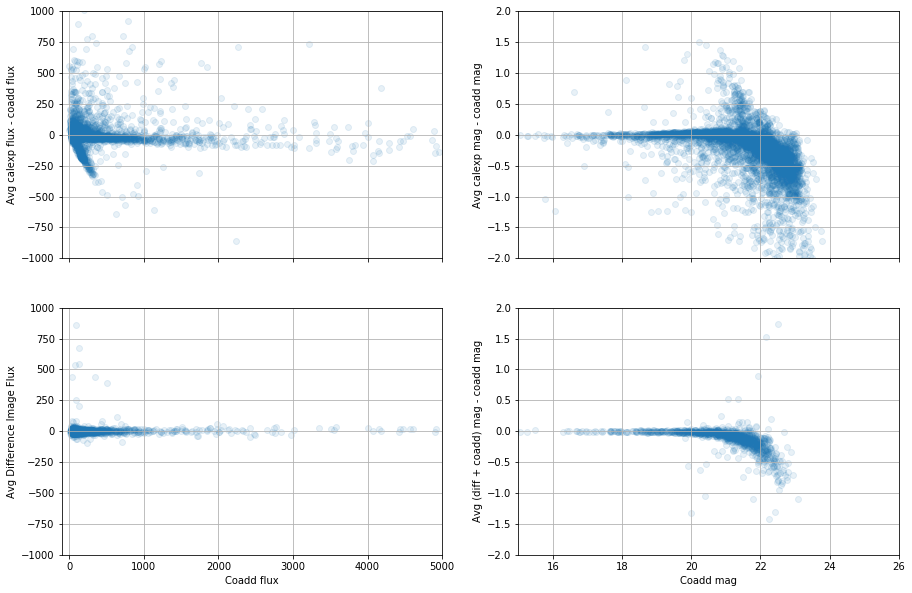

In [312]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(meas_cut, weightedFluxAvgs - meas_cut, alpha=0.1)
subs[0,0].grid(True)
subs[0,0].set_ylim(-1000, 1000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[1,0].scatter(meas_cut2, weightedDiffAvgs, alpha=0.1)
subs[1,0].grid(True)
subs[0,0].set_xlim(-100, 5000)
subs[0,1].scatter(meas_mag, weightedMagAvgs, alpha=0.1)
#subs[0,1].set_xlabel('Coadd mag')
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].scatter(meas_mag2, weightedMagDiffAvgs, alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-2,2)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

The above plots show that for both the calexps and the diffims, bright stars are on average measured to have the same fluxes and magnitude in the calexps as in the coadds, with flux~0 in the difference images, as would be expected. However, at fainter magnitudes, there is a bias where the average calexp magnitude is brighter than the magnitude in the coadd. In the diffims, there is a bias in the fainter objects towards positive flux measurements. This awaits interpretation.

### Same thing, but using the coadd_meas catalog:

(15, 26)

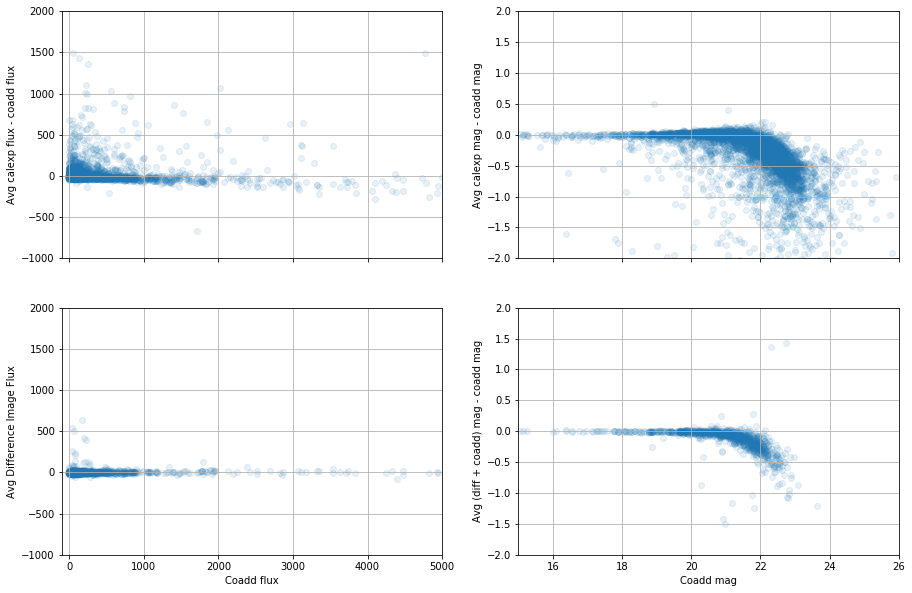

In [313]:
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(meas_cut_meas, weightedFluxAvgs_meas - meas_cut_meas, alpha=0.1)
subs[0,0].grid(True)
subs[0,0].set_ylim(-1000, 2000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[1,0].scatter(meas_cut2_meas, weightedDiffAvgs_meas, alpha=0.1)
subs[1,0].grid(True)
subs[0,0].set_xlim(-100, 5000)
subs[1,0].set_xlim(-100, 5000)
subs[0,1].scatter(meas_mag_meas, weightedMagAvgs_meas, alpha=0.1)
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].scatter(meas_mag2_meas, weightedMagDiffAvgs_meas, alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-2,2)
subs[1,1].grid(True)
subs[0,1].set_xlim(15, 26)

# How much scatter is there between the calexp fluxes/magnitudes for the same object? Similarly, how much scatter is there between the diffim fluxes/magnitudes for the same object?

In [314]:
calexp_var = np.average((calexp_flux_cut - weightedFluxAvgs[:,None])**2, weights=fluxWeights, axis=1)
calexp_stds = calexp_var**0.5
diff_var = np.average((diff_flux_cut - weightedDiffAvgs[:,None])**2, weights=diffWeights, axis=1)
diff_stds = diff_var**0.5

In [315]:
calexp_mag_var = np.average((mags - weightedMagAvgs[:,None])**2, weights=magWeights, axis=1)
calexp_mag_std = calexp_mag_var**0.5

diff_mag_var = np.average((diffMags - weightedMagDiffAvgs[:,None])**2, weights=diffMagWeights, axis=1)
diff_mag_std = diff_mag_var**0.5

(-0.01, 1.5)

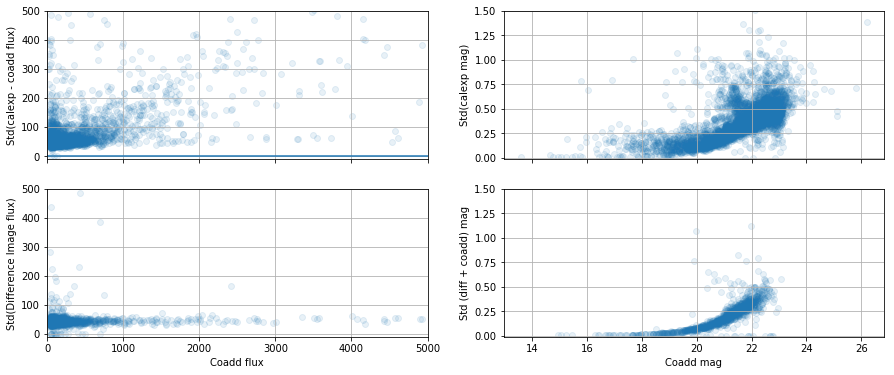

In [316]:
fig, subs = plt.subplots(2, 2, figsize=(15,6), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(meas_cut, calexp_stds, alpha=0.1)
subs[0,0].axhline(0)
subs[1,0].set_xlabel('Coadd flux')
subs[0,0].set_ylabel('Std(calexp - coadd flux)')
subs[1,0].set_ylabel('Std(Difference Image flux)')
subs[1,0].scatter(meas_cut2, diff_stds, alpha=0.1)
subs[0,0].set_xlim(0, 5000)
subs[0,0].set_ylim(-10, 500)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,1].scatter(meas_mag, calexp_mag_std, alpha=0.1)
subs[0,1].set_ylabel('Std(calexp mag)')
subs[0,1].grid(True)
subs[1,1].scatter(meas_mag2, diff_mag_std, alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Std (diff + coadd) mag')
subs[1,1].grid(True)
subs[1,1].set_ylim(-0.01,1.5)

In [62]:
seeing_array = np.array([seeingDict[i]['calexp'] for i in range(lenCalexp)])
diff_seeing_array = np.array([seeingDict[i]['diffim'] for i in range(lenCalexp)])

In [63]:
c = coadd.getPhotoCalib()

In [65]:
def percentile16(x):
    return np.percentile(x, 16)
def percentile84(x):
    return np.percentile(x, 84)

## Are there systematic differences between observations of the same object at different seeing levels?
We split up the objects into bins in magnitude, then look at trends in the magnitude residuals in each bin.

Magnitudes = 13.61 - 15.61, 8 calexp objects 4 diffim objects,


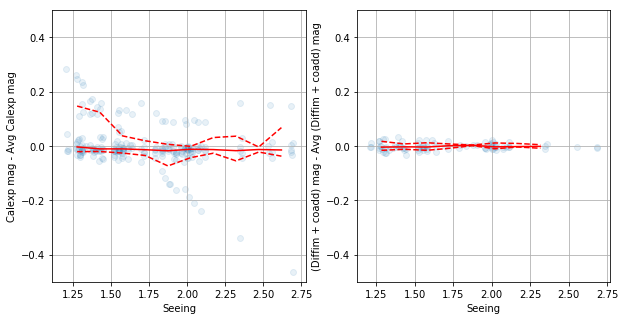

Magnitudes = 15.61 - 17.61, 56 calexp objects 17 diffim objects,


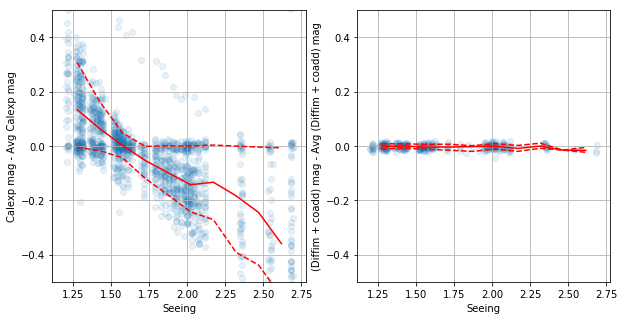

Magnitudes = 17.61 - 19.61, 343 calexp objects 112 diffim objects,


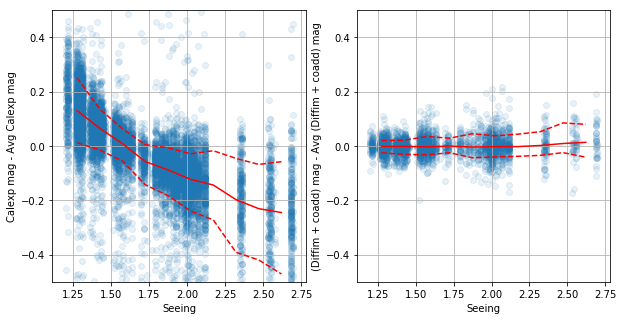

Magnitudes = 19.61 - 21.61, 1740 calexp objects 609 diffim objects,


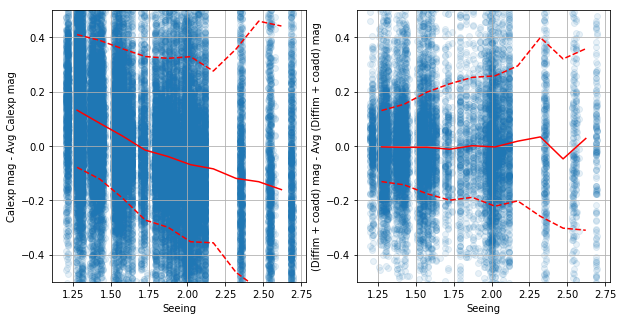

Magnitudes = 21.61 - 23.61, 2809 calexp objects 934 diffim objects,


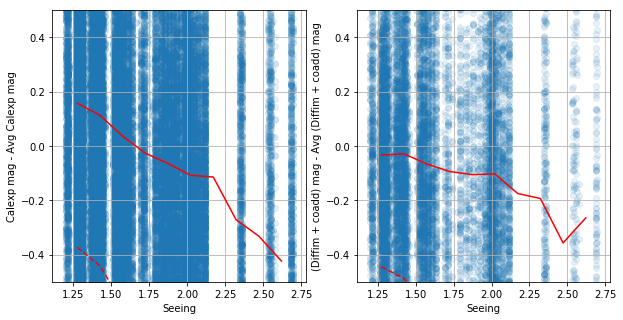

Magnitudes = 23.61 - 25.61, 24 calexp objects 9 diffim objects,


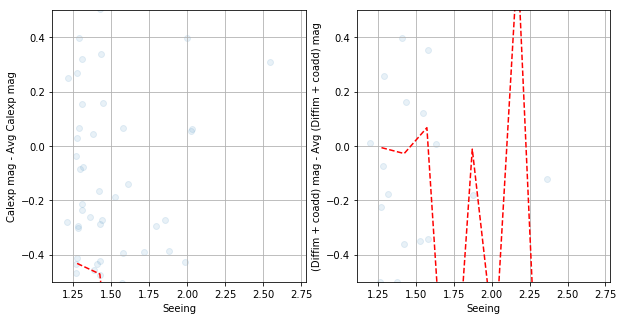

In [318]:
meas_bins = np.arange(meas_mag.min(), meas_mag.max(), 2)
seeing_b = seeing_array * np.ones(len(meas_mag))[:,None]
seeing_b2 = seeing_array * np.ones(len(meas_mag2))[:,None]
sseeing = seeing_array.argsort()
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1])
    mm_ind2 = (meas_mag2 > meas_bins[mm]) & (meas_mag2 < meas_bins[mm + 1])
    mm_stars = meas_mag[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s calexp objects' % len(mm_stars), '%s diffim objects,' % len(meas_mag2[mm_ind2]))
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0) & (mags[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)
    p16 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16)
    p50 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median)
    p84 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84)

    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    subs[0].scatter(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], alpha=0.1)
    subs[1].scatter(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], alpha=0.1)

    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile16)
        p50_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=np.median)
        p84_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile84)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    subs[0].set_ylim(-0.5, 0.5)
    subs[1].set_ylim(-0.5, 0.5)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('Seeing')
    subs[1].set_xlabel('Seeing')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    plt.show()

### Can the isolation of the source explain the trend in magnitude vesus seeing?

In [319]:
import matplotlib
import matplotlib.cm as cm

blendedness = refCatalog['base_Blendedness_abs'][mask.any(axis=1)]
blendedness2 = refCatalog['base_Blendedness_abs'][mask2.any(axis=1)]
#norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
#mapper = cm.ScalarMappable(norm=norm)
#pointColors = mapper.to_rgba(blendedness)
#pointColors2 = mapper.to_rgba(blendedness2)

Magnitudes = 13.61 - 15.61, 8 calexp objects 4 diffim objects,


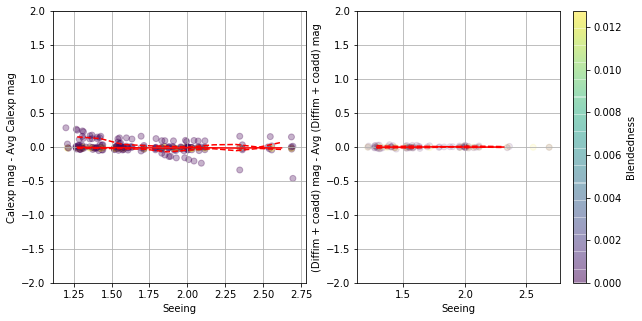

Magnitudes = 15.61 - 17.61, 56 calexp objects 17 diffim objects,


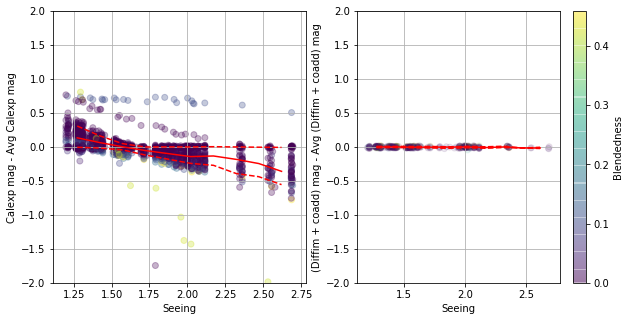

Magnitudes = 17.61 - 19.61, 343 calexp objects 112 diffim objects,


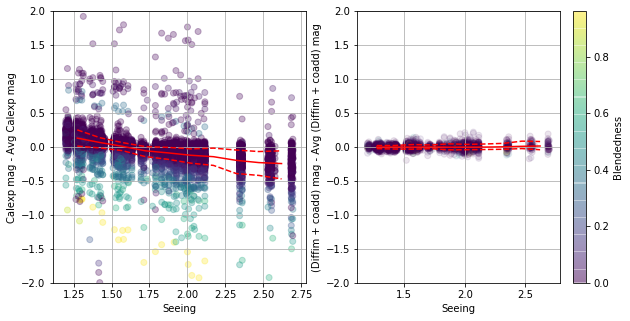

Magnitudes = 19.61 - 21.61, 1740 calexp objects 609 diffim objects,


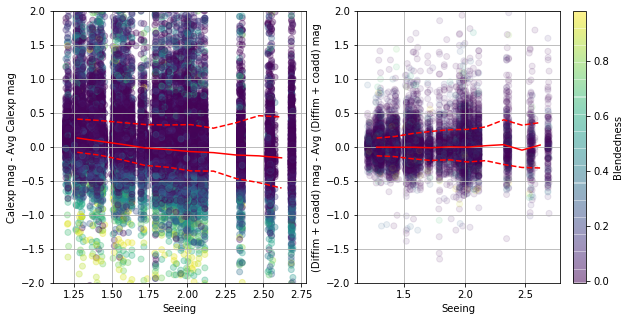

Magnitudes = 21.61 - 23.61, 2809 calexp objects 934 diffim objects,


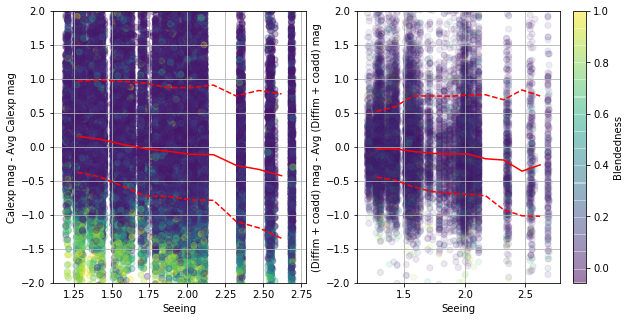

Magnitudes = 23.61 - 25.61, 24 calexp objects 9 diffim objects,


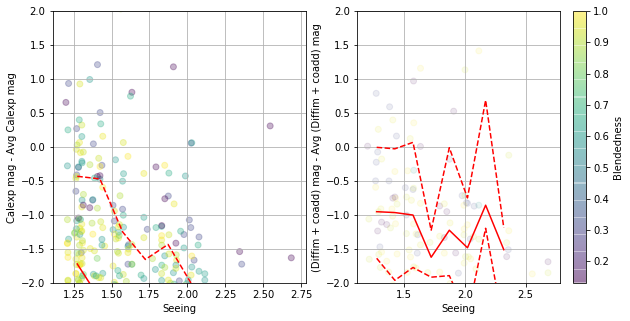

In [321]:
color_array = np.ones(len(seeing_array))[None,:] * blendedness[:,None]
color_array2 = np.ones(len(seeing_array))[None,:] * blendedness2[:,None]
cm = plt.cm.get_cmap('viridis')
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1])
    mm_ind2 = (meas_mag2 > meas_bins[mm]) & (meas_mag2 < meas_bins[mm + 1])
    mm_stars = meas_mag[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s calexp objects' % len(mm_stars), '%s diffim objects,' % len(meas_mag2[mm_ind2]))
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0) & (mags[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)
    p16 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16)
    p50 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median)
    p84 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84)

    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    #im = subs[0].scatter(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], alpha=0.1, c=color_array[mm_ind][plot_ind])
    im = subs[0].scatter(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], alpha=0.3, c=color_array[mm_ind][plot_ind], 
                        cmap=cm)
    im2 = subs[1].scatter(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], alpha=0.1, 
                          c=color_array2[mm_ind2][plot_diff_ind], cmap=cm)

    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile16)
        p50_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=np.median)
        p84_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile84)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    subs[0].set_ylim(-2, 2)
    subs[1].set_ylim(-2, 2)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('Seeing')
    subs[1].set_xlabel('Seeing')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    cb = plt.colorbar(im)
    cb.set_label('Blendedness')
    plt.show()

### It's not clear that blendedness alone explains the trend in $\Delta \mathrm{mag}$ versus seeing. Let's look at some individual objects:

Object id 43158593054179692, Mag = 19.35, Blend = 0.000, Extendedness = 1.0


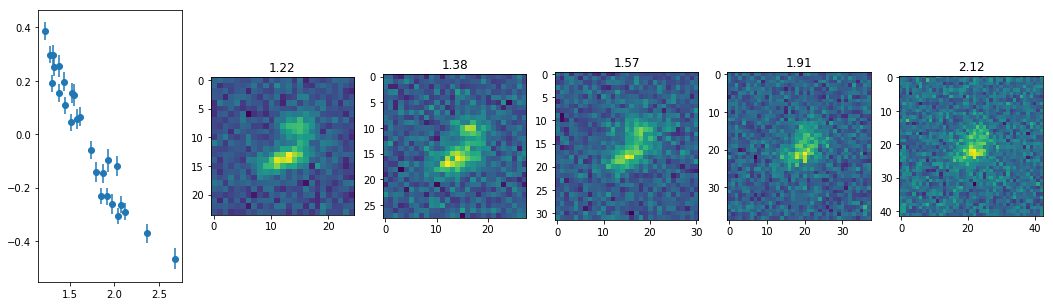

Object id 43158593054179951, Mag = 19.66, Blend = 0.000, Extendedness = 0.0


/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


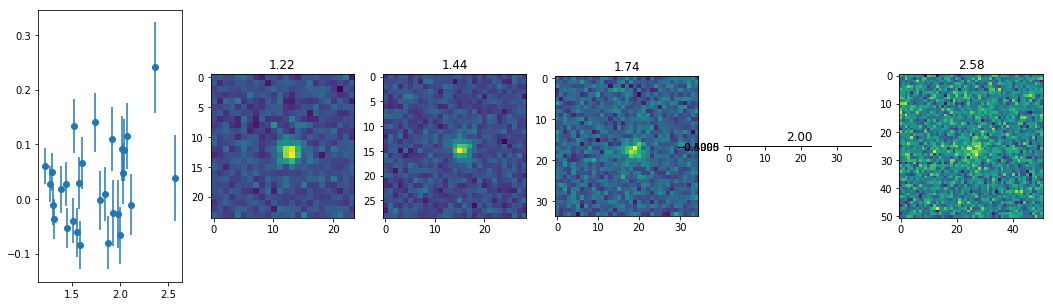

Object id 43158593054180032, Mag = 19.39, Blend = 0.000, Extendedness = 1.0


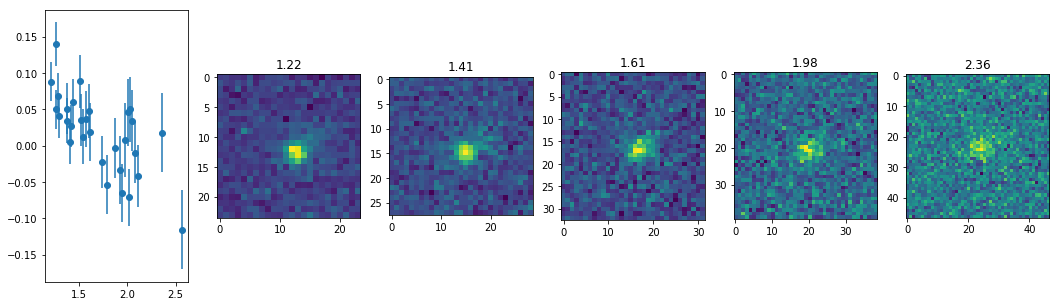

Object id 43158593054180993, Mag = 19.77, Blend = 0.000, Extendedness = 1.0


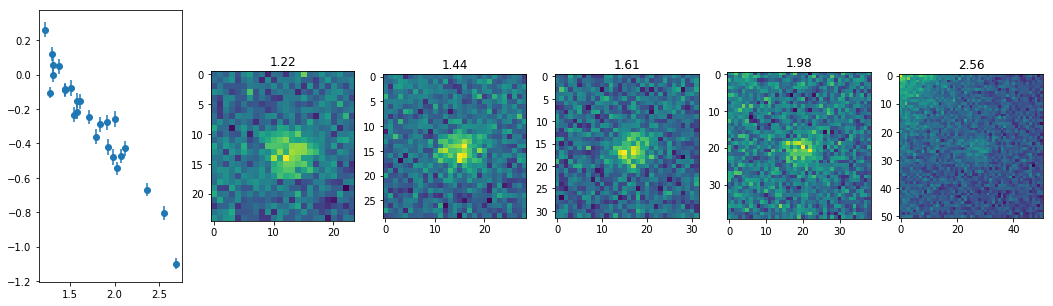

Object id 43158593054181177, Mag = 19.23, Blend = 0.000, Extendedness = 1.0


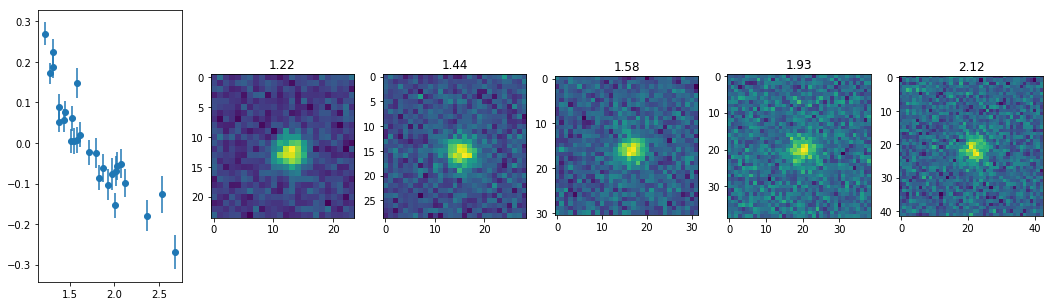

Object id 43158593054181229, Mag = 19.97, Blend = 0.000, Extendedness = 1.0


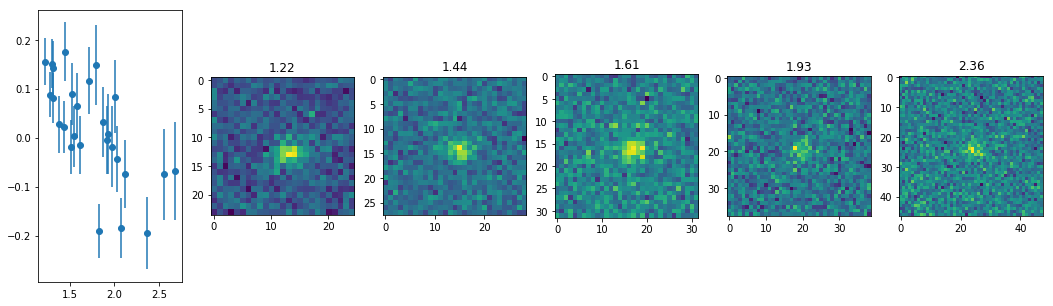

Object id 43158593054181508, Mag = 19.94, Blend = 0.000, Extendedness = 1.0


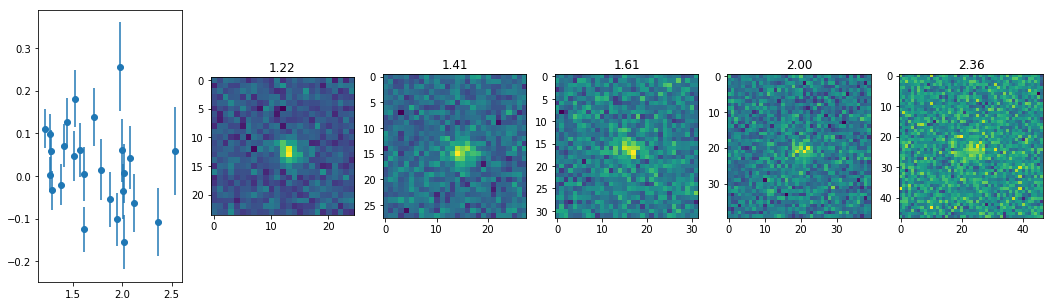

Object id 43158593054181942, Mag = 18.81, Blend = 0.000, Extendedness = 1.0


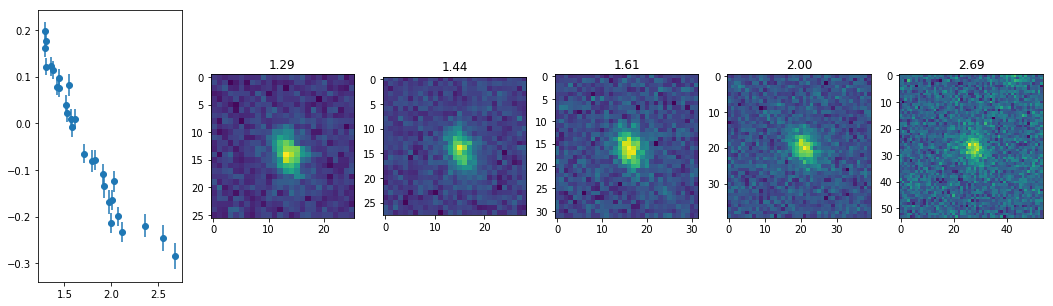

Object id 43158593054182810, Mag = 19.80, Blend = 0.000, Extendedness = 1.0


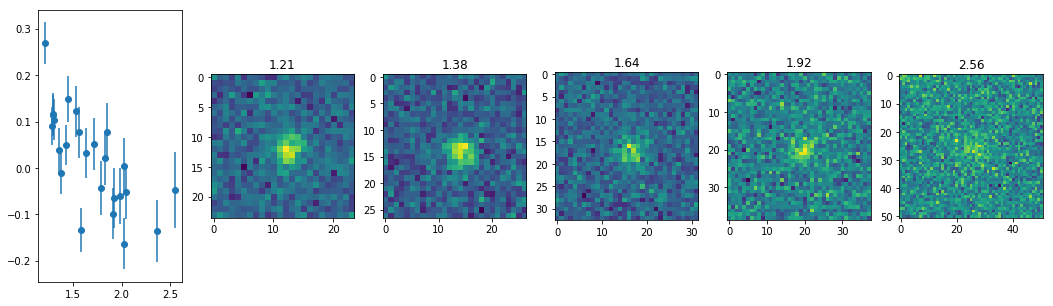

Object id 43158593054182900, Mag = 17.60, Blend = 0.000, Extendedness = 1.0


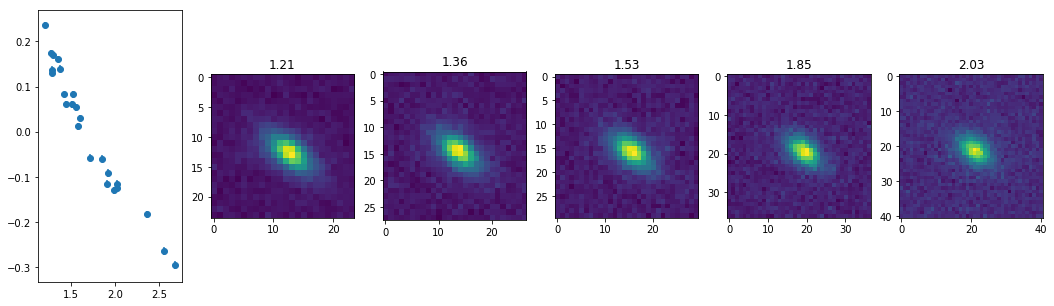

Object id 43158593054183846, Mag = 18.84, Blend = 0.000, Extendedness = 0.0


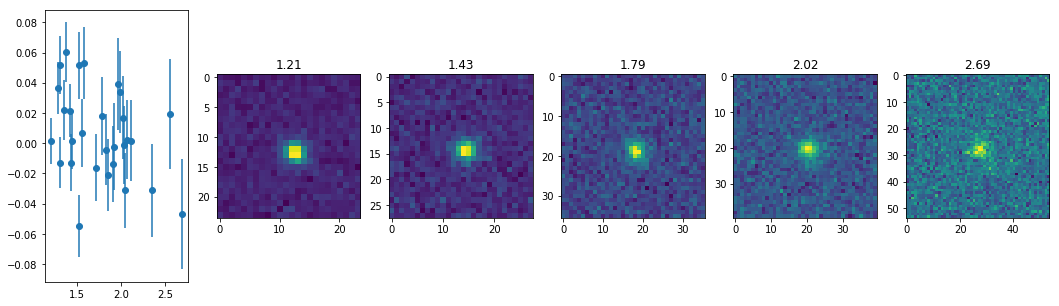

Object id 43158593054183872, Mag = 19.83, Blend = 0.000, Extendedness = 1.0


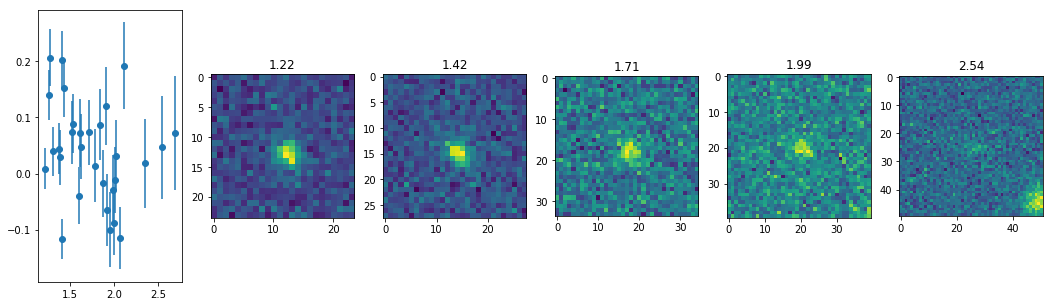

Object id 43158593054184690, Mag = 18.91, Blend = 0.000, Extendedness = 0.0


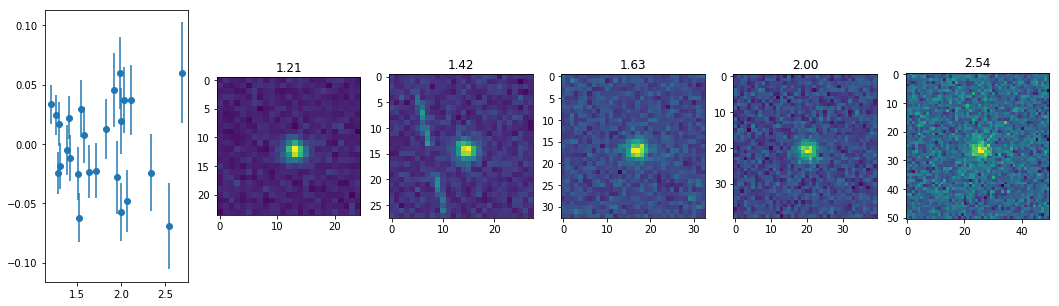

Object id 43158593054184720, Mag = 19.31, Blend = 0.000, Extendedness = 1.0


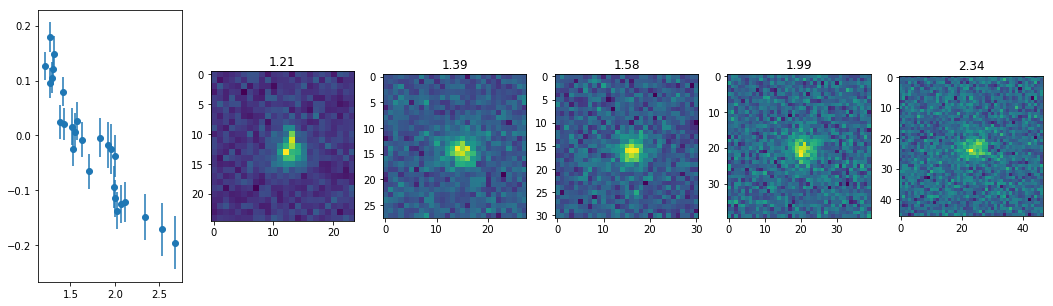

Object id 43158593054184797, Mag = 19.11, Blend = 0.000, Extendedness = 1.0


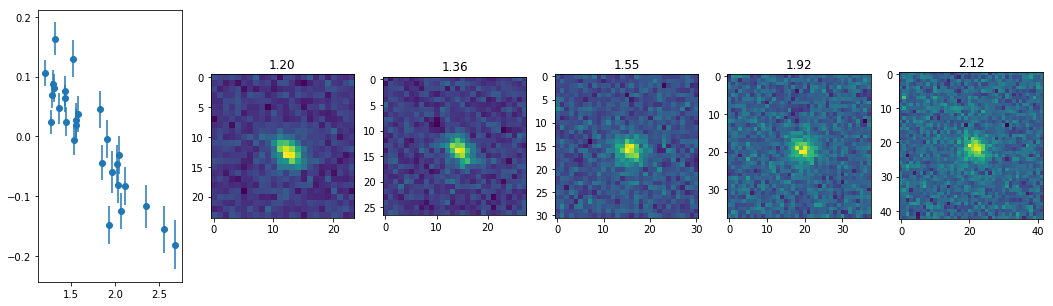

Object id 43158593054185029, Mag = 19.86, Blend = 0.000, Extendedness = 1.0


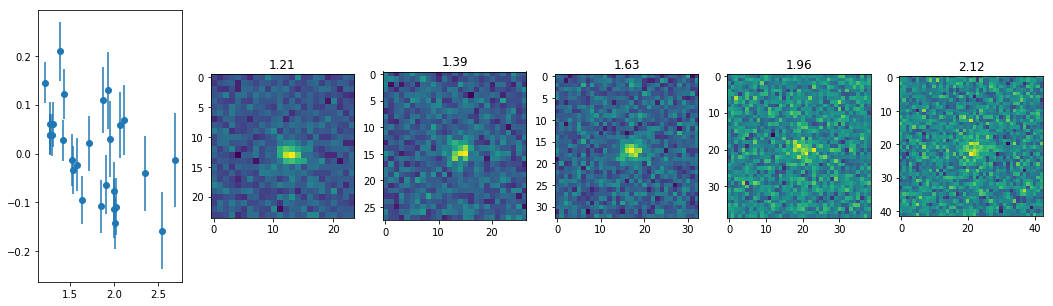

In [323]:
a = 0
blend = np.array(refCatalog[mask.any(axis=1)]['base_Blendedness_abs'])
names = np.array(refCatalog[mask.any(axis=1)]['id'])
extended = np.array(refCatalog[mask.any(axis=1)]['base_ClassificationExtendedness_value'])
extended2 = np.array(refCatalog[mask2.any(axis=1)]['base_ClassificationExtendedness_value'])
meas_xs = np.array(refCatalog[mask.any(axis=1)]['slot_Centroid_x'])
meas_ys = np.array(refCatalog[mask.any(axis=1)]['slot_Centroid_y'])
for mm, m in enumerate(meas_mag):
    if a > 15:
        break
    if m > 20:
        continue
    ind = mags[mm] != 0
    print('Object id %s,' % names[mm], 'Mag = %.2f,' % m, 'Blend = %.3f,' % blend[mm], 
          'Extendedness = %s' % extended[mm])
    fig, subs = plt.subplots(1, 6, figsize=(18, 5))
    subs[0].errorbar(seeing_array[ind], mags[mm][ind], yerr=magWeights[mm][ind]**-0.5, marker='o',
                 linestyle="None")
    point = geom.Point2D(meas_xs[mm], meas_ys[mm])
    cuts = []
    seeings = []
    seeings = seeing_array[ind]
    step = (len(seeings) - 1) // 4
    if step == 0:
        plt.close()
        continue
    for ii, i in enumerate(np.flatnonzero(ind)[seeings.argsort()[::step]]):
        c = butler.get('calexp', tract=9813, filter='HSC-I', ccd=int(inputs.ccds['ccd'][i]),
                       visit=int(inputs.ccds['visit'][i])) 
        calexpPoint = psf.getWcs(i).skyToPixel(coaddWcs_diffim.pixelToSky(point))
        seeing = c.getPsf().computeShape().getDeterminantRadius()
        cut = c.image.array[int(calexpPoint[1] - seeing * 10): int(calexpPoint[1] + seeing * 10),
                           int(calexpPoint[0] - seeing * 10): int(calexpPoint[0] + seeing * 10)]
        subs[ii + 1].imshow(cut)
        subs[ii + 1].set_title('%.2f' % seeing)
    plt.show()
    a += 1

### Reconsider $\Delta \mathrm{mag}$ versus seeing with only objects with extendedness = 0:

Magnitudes = 13.61 - 15.61, 5 calexp objects 3 diffim objects,


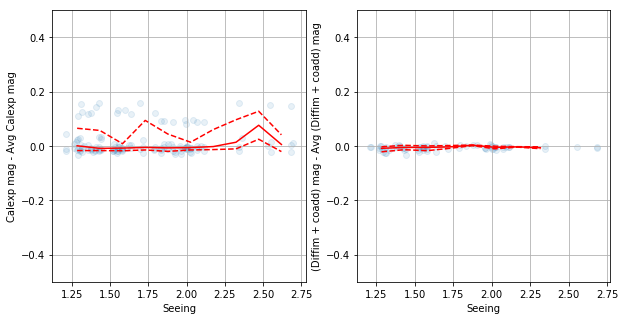

Magnitudes = 15.61 - 17.61, 16 calexp objects 4 diffim objects,


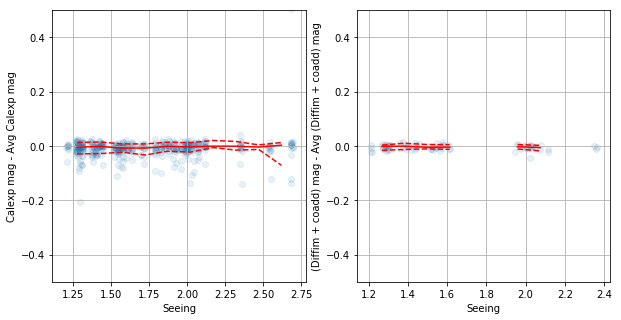

Magnitudes = 17.61 - 19.61, 30 calexp objects 11 diffim objects,


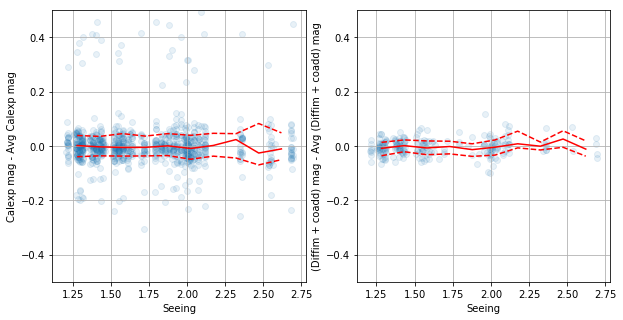

Magnitudes = 19.61 - 21.61, 75 calexp objects 19 diffim objects,


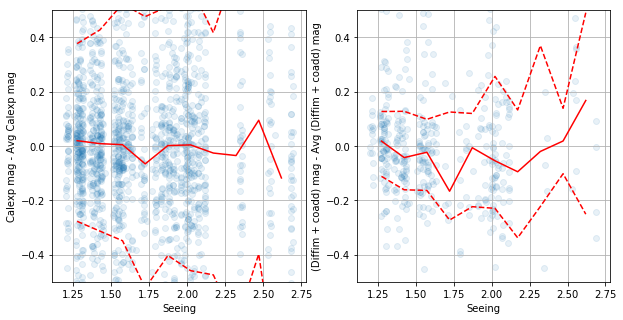

Magnitudes = 21.61 - 23.61, 463 calexp objects 157 diffim objects,


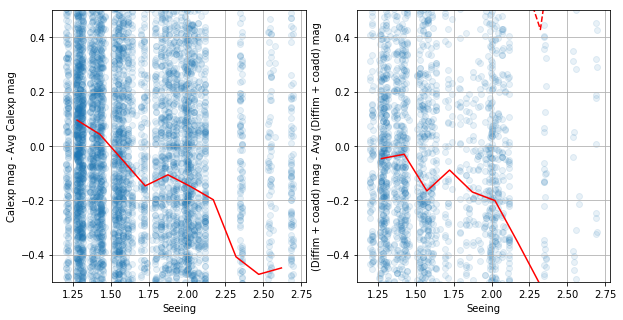

Magnitudes = 23.61 - 25.61, 16 calexp objects 5 diffim objects,


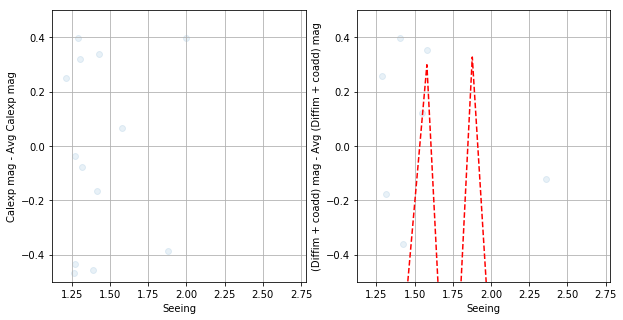

In [332]:
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1]) & (extended == 0)
    mm_ind2 = (meas_mag2 > meas_bins[mm]) & (meas_mag2 < meas_bins[mm + 1])  & (extended2 == 0)
    mm_stars = meas_mag[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s calexp objects' % len(mm_stars), '%s diffim objects,' % len(meas_mag2[mm_ind2]))
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0) & (mags[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)
    p16 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16)
    p50 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median)
    p84 = scipy.stats.binned_statistic(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84)

    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    subs[0].scatter(seeing_b[mm_ind][plot_ind], plot_mags[plot_ind], alpha=0.1)
    subs[1].scatter(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], alpha=0.1)

    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile16)
        p50_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=np.median)
        p84_diff = scipy.stats.binned_statistic(seeing_b2[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], statistic=percentile84)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    subs[0].set_ylim(-0.5, 0.5)
    subs[1].set_ylim(-0.5, 0.5)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('Seeing')
    subs[1].set_xlabel('Seeing')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    plt.show()

### Back to plots of the average vs catalog fluxes and magnitudes in calexps and diffims with only the extendedness=0 objects:

(15, 26)

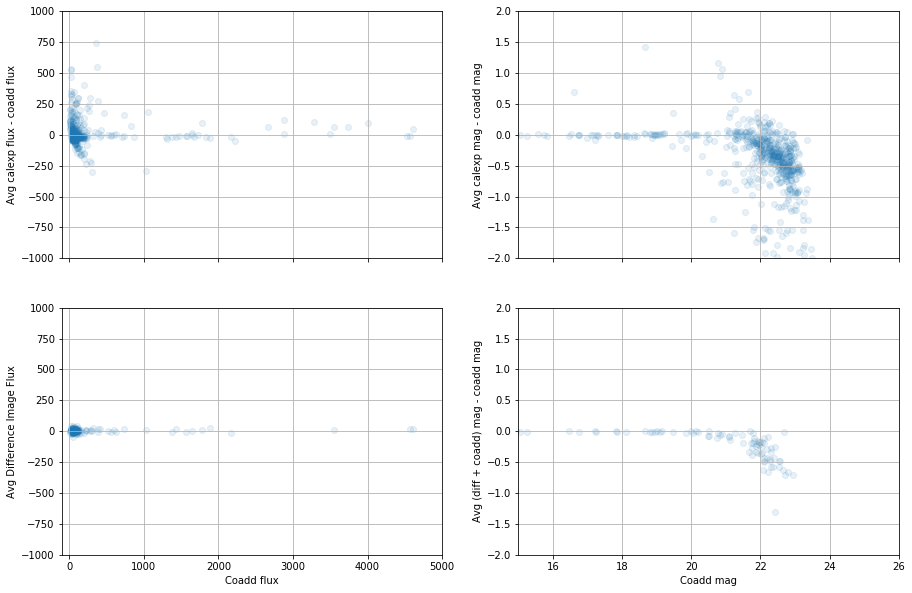

In [325]:
ext_ind = extended == 0
ext_ind2 = extended2 == 0
fig, subs = plt.subplots(2,2, figsize=(15,10), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(meas_cut[ext_ind], (weightedFluxAvgs - meas_cut)[ext_ind], alpha=0.1)
subs[0,0].grid(True)
subs[0,0].set_ylim(-1000, 1000)
subs[0,0].set_ylabel('Avg calexp flux - coadd flux')
subs[1,0].set_xlabel('Coadd flux')
subs[1,0].set_ylabel('Avg Difference Image Flux')
subs[1,0].scatter(meas_cut2[ext_ind2], weightedDiffAvgs[ext_ind2], alpha=0.1)
subs[1,0].grid(True)
subs[0,0].set_xlim(-100, 5000)
subs[0,1].scatter(meas_mag[ext_ind], weightedMagAvgs[ext_ind], alpha=0.1)
#subs[0,1].set_xlabel('Coadd mag')
subs[0,1].set_ylabel('Avg calexp mag - coadd mag')
subs[0,1].grid(True)
subs[1,1].scatter(meas_mag2[ext_ind2], weightedMagDiffAvgs[ext_ind2], alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Avg (diff + coadd) mag - coadd mag')
subs[1,1].set_ylim(-2,2)
subs[1,1].grid(True)
subs[0,1].set_xlim(15,26)

### And the standard deviation for only objects with extendedness = 0:

(-0.01, 1.5)

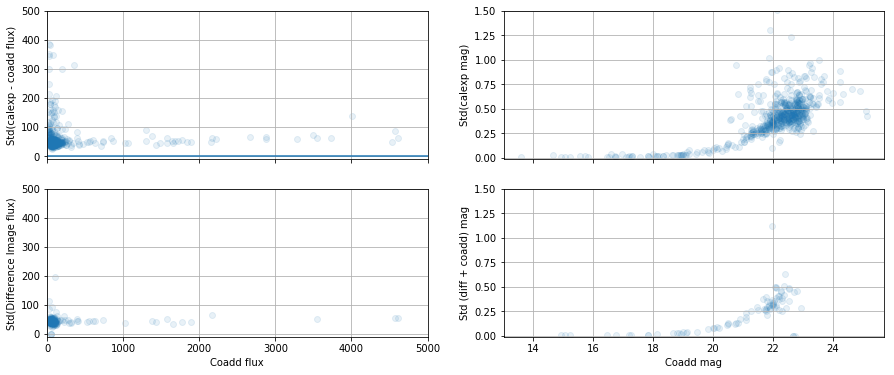

In [326]:
fig, subs = plt.subplots(2, 2, figsize=(15,6), sharex='col', sharey='col', facecolor='w')
subs[0,0].scatter(meas_cut[ext_ind], calexp_stds[ext_ind], alpha=0.1)
subs[0,0].axhline(0)
subs[1,0].set_xlabel('Coadd flux')
subs[0,0].set_ylabel('Std(calexp - coadd flux)')
subs[1,0].set_ylabel('Std(Difference Image flux)')
subs[1,0].scatter(meas_cut2[ext_ind2], diff_stds[ext_ind2], alpha=0.1)
subs[0,0].set_xlim(0, 5000)
subs[0,0].set_ylim(-10, 500)
subs[0,0].grid(True)
subs[1,0].grid(True)
subs[0,1].scatter(meas_mag[ext_ind], calexp_mag_std[ext_ind], alpha=0.1)
subs[0,1].set_ylabel('Std(calexp mag)')
subs[0,1].grid(True)
subs[1,1].scatter(meas_mag2[ext_ind2], diff_mag_std[ext_ind2], alpha=0.1)
subs[1,1].set_xlabel('Coadd mag')
subs[1,1].set_ylabel('Std (diff + coadd) mag')
subs[1,1].grid(True)
subs[1,1].set_ylim(-0.01,1.5)

##  Are there systematic differences between the CCDs?

(4983, 188) (1685, 188) (4983, 188) (1685, 188)
Magnitudes = 13.61 - 15.61, 8 calexp objects 4 diffim objects,


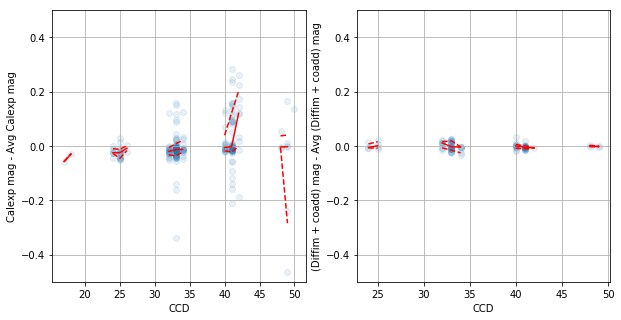

Magnitudes = 15.61 - 17.61, 56 calexp objects 17 diffim objects,


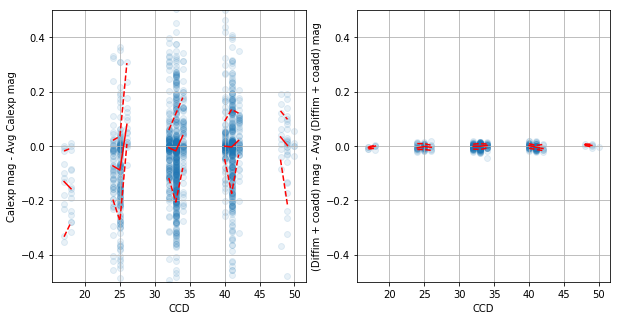

Magnitudes = 17.61 - 19.61, 343 calexp objects 112 diffim objects,


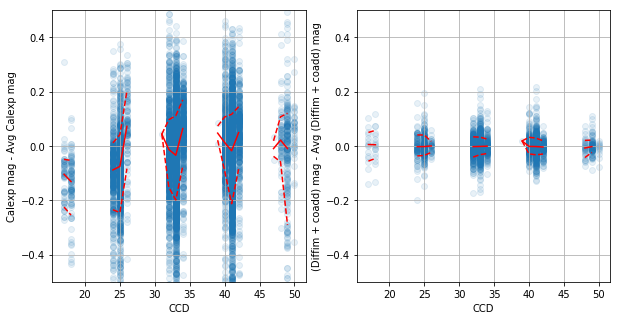

Magnitudes = 19.61 - 21.61, 1740 calexp objects 609 diffim objects,


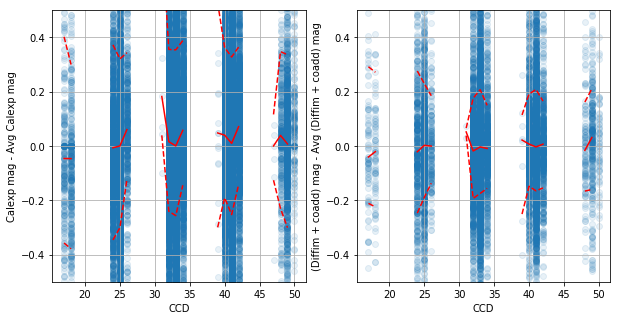

Magnitudes = 21.61 - 23.61, 2809 calexp objects 934 diffim objects,


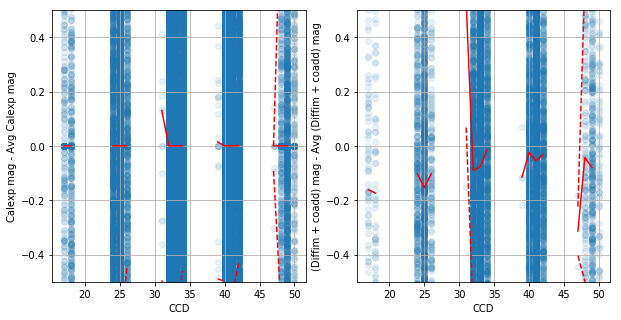

Magnitudes = 23.61 - 25.61, 24 calexp objects 9 diffim objects,


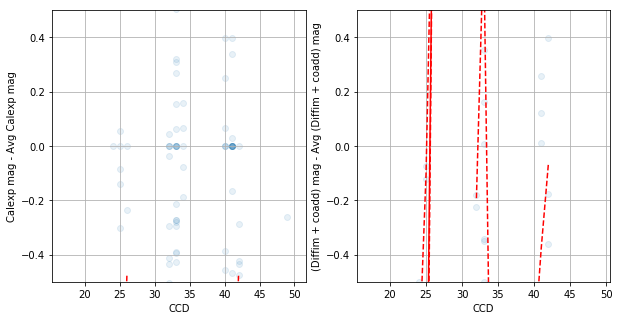

In [331]:
ccds = inputs.ccds['ccd'] * np.ones(len(meas_mag))[:,None]
ccds_diffim = inputs.ccds['ccd'] * np.ones(len(meas_mag2))[:,None]
bins = np.arange(ccds.min() - 0.5, ccds.max() + 0.5, 1)
print(ccds.shape, ccds_diffim.shape, mags.shape, diffMags.shape)
for mm, m in enumerate(meas_bins[:-1]):
    mm_ind = (meas_mag > meas_bins[mm]) & (meas_mag < meas_bins[mm + 1])
    mm_ind2 = (meas_mag2 > meas_bins[mm]) & (meas_mag2 < meas_bins[mm + 1])
    mm_stars = meas_mag[mm_ind]
    print('Magnitudes = %.2f - %.2f,' % (m, m+2), '%s calexp objects' % len(mm_stars), '%s diffim objects,' % len(meas_mag2[mm_ind2]))
    plot_mags = mags[mm_ind]
    plot_ind = np.isfinite(mags[mm_ind]) & (magWeights[mm_ind] != 0)
    plot_diffs = diffMags[mm_ind2]
    plot_diff_ind = np.isfinite(diffMags[mm_ind2]) & (diffMagWeights[mm_ind2] != 0)

    p16 = scipy.stats.binned_statistic(ccds[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile16, bins=bins)
    p50 = scipy.stats.binned_statistic(ccds[mm_ind][plot_ind], plot_mags[plot_ind], statistic=np.median, bins=bins)
    p84 = scipy.stats.binned_statistic(ccds[mm_ind][plot_ind], plot_mags[plot_ind], statistic=percentile84, bins=bins)
    
    fig, subs = plt.subplots(1, 2, figsize=(10, 5))
    subs[0].scatter(ccds[mm_ind][plot_ind], plot_mags[plot_ind], alpha=0.1)
    subs[1].scatter(ccds_diffim[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], alpha=0.1)

    subs[0].plot(p16[1][:-1] + 0.5 * np.diff(p16[1])[0], p16[0], linestyle='--', color='r')
    subs[0].plot(p50[1][:-1] + 0.5 * np.diff(p50[1])[0], p50[0], color='r')
    subs[0].plot(p84[1][:-1] + 0.5 * np.diff(p84[1])[0], p84[0], linestyle='--', color='r')
    if mm_ind2.sum() != 0:
        p16_diff = scipy.stats.binned_statistic(ccds_diffim[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind],
                                                statistic=percentile16, bins=bins)
        p50_diff = scipy.stats.binned_statistic(ccds_diffim[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind], 
                                                statistic=np.median, bins=bins)
        p84_diff = scipy.stats.binned_statistic(ccds_diffim[mm_ind2][plot_diff_ind], plot_diffs[plot_diff_ind],
                                                statistic=percentile84, bins=bins)
        subs[1].plot(p16_diff[1][:-1] + 0.5 * np.diff(p16_diff[1])[0], p16_diff[0], linestyle='--', color='r')
        subs[1].plot(p50_diff[1][:-1] + 0.5 * np.diff(p50_diff[1])[0], p50_diff[0], color='r')
        subs[1].plot(p84_diff[1][:-1] + 0.5 * np.diff(p84_diff[1])[0], p84_diff[0], linestyle='--', color='r')
    subs[0].set_ylim(-0.5, 0.5)
    subs[1].set_ylim(-0.5, 0.5)
    subs[0].grid(True)
    subs[1].grid(True)
    subs[0].set_xlabel('CCD')
    subs[1].set_xlabel('CCD')
    subs[0].set_ylabel('Calexp mag - Avg Calexp mag')
    subs[1].set_ylabel('(Diffim + coadd) mag - Avg (Diffim + coadd) mag')
    plt.show()

## What is the $\chi^2/$dof of the lightcurves?

Assume a model in which the flux is constant.

In [328]:
chi2_calexp = (calexp_flux_cut - weightedFluxAvgs[:, None])**2 * fluxWeights
calexp_ind = np.isfinite(calexp_flux_cut) & (fluxWeights != 0)
dof_calexp = calexp_ind.sum(axis=1) - 1
chi2dof_calexp = chi2_calexp.sum(axis=1) / dof_calexp 

chi2_diffim = (diff_flux_cut - weightedDiffAvgs[:, None])**2 * diffWeights
diffim_ind = np.isfinite(diff_flux_cut) & (diffWeights != 0)
dof_diffim = diffim_ind.sum(axis=1) - 1
chi2dof_diffim = chi2_diffim.sum(axis=1) / dof_diffim 

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


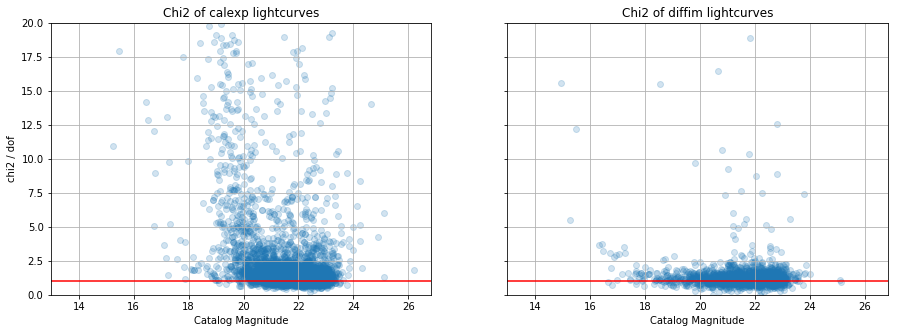

In [329]:
fig, subs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True, facecolor='w')
subs[0].scatter(meas_mag, chi2dof_calexp, alpha=0.2)
subs[0].set_ylim(0, 20)
subs[0].axhline(1, color='r')
subs[0].grid(True)
subs[0].set_ylabel('chi2 / dof')
subs[0].set_xlabel('Catalog Magnitude')
subs[0].set_title('Chi2 of calexp lightcurves')
subs[1].scatter(meas_mag2, chi2dof_diffim, alpha=0.2)
subs[1].axhline(1, color='r')
subs[1].set_xlabel('Catalog Magnitude')
subs[1].set_title('Chi2 of diffim lightcurves')
subs[1].grid(True)


### What about just the objects with extendedness = 0?

Text(0.5, 1.0, 'Chi2 of diffim lightcurves (extendedness=0 objects only)')

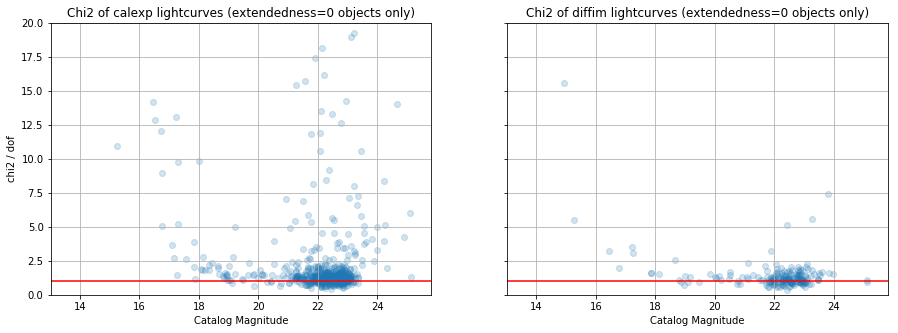

In [330]:
ext_ind = extended == 0
ext_ind2 = extended2 == 0

fig, subs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True, facecolor='w')
subs[0].scatter(meas_mag[ext_ind], chi2dof_calexp[ext_ind], alpha=0.2)
subs[0].set_ylim(0, 20)
subs[0].axhline(1, color='r')
subs[0].grid(True)
subs[0].set_ylabel('chi2 / dof')
subs[0].set_xlabel('Catalog Magnitude')
subs[0].set_title('Chi2 of calexp lightcurves (extendedness=0 objects only)')

subs[1].scatter(meas_mag2[ext_ind2], chi2dof_diffim[ext_ind2], alpha=0.2)
subs[1].axhline(1, color='r')
subs[1].grid(True)
subs[1].set_xlabel('Catalog Magnitude')
subs[1].set_title('Chi2 of diffim lightcurves (extendedness=0 objects only)')

# Appendix

### Make some lightcurves of random objects

id = 43158593054179643
-4.227695017020166 0.4803225272798139
-4.230241518959944


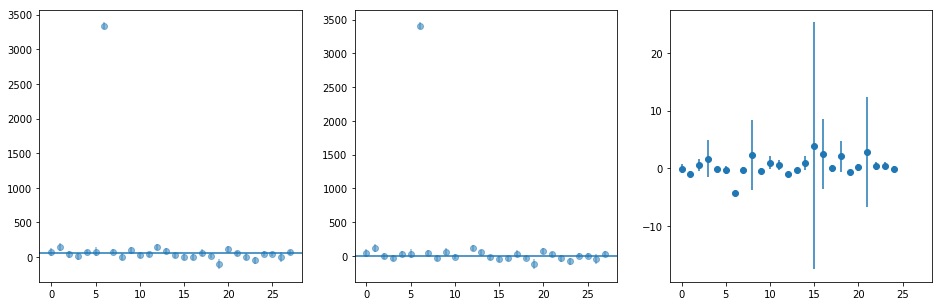

id = 43158593054179713
-1.0089642760270336 0.7574324743629209
-1.009049148919882


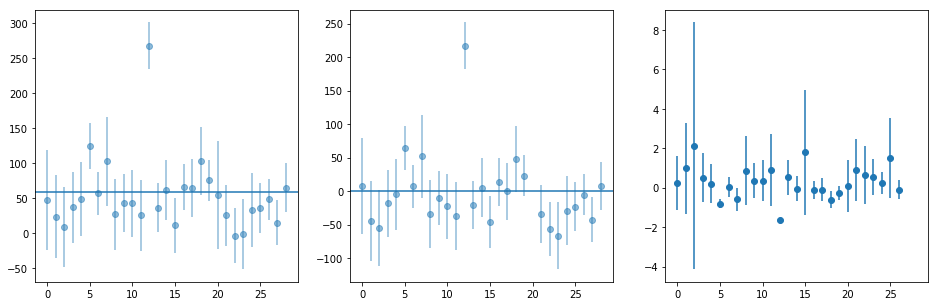

id = 43158593054179737
-1.0390996661628367 0.7430772215297512
-1.0469807714078465


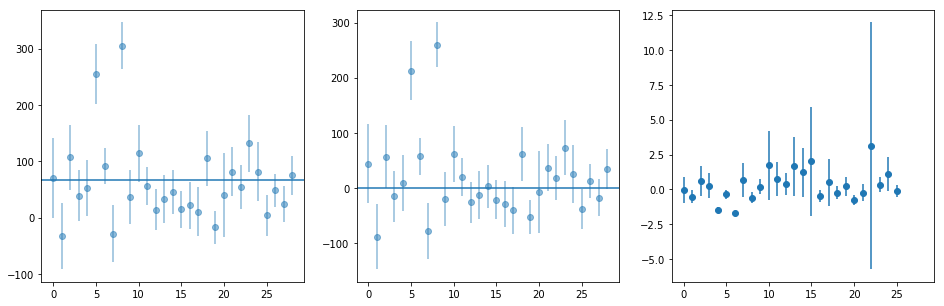

id = 43158593054179739
-1.0579616296433294 0.5899888462418166
-1.1055203013379624


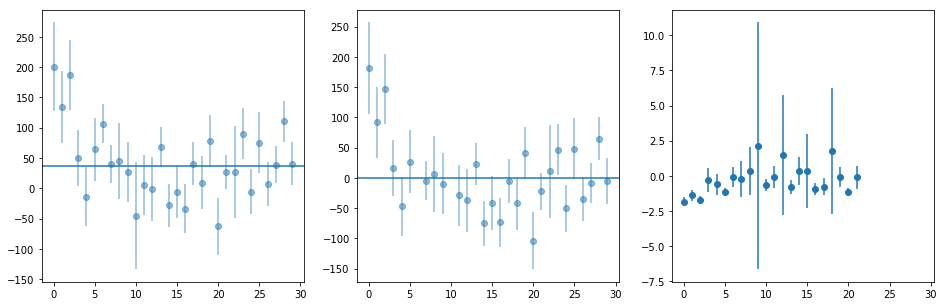

id = 43158593054179788
-2.0223750284742077 0.9203505052893994
-2.043300464868547


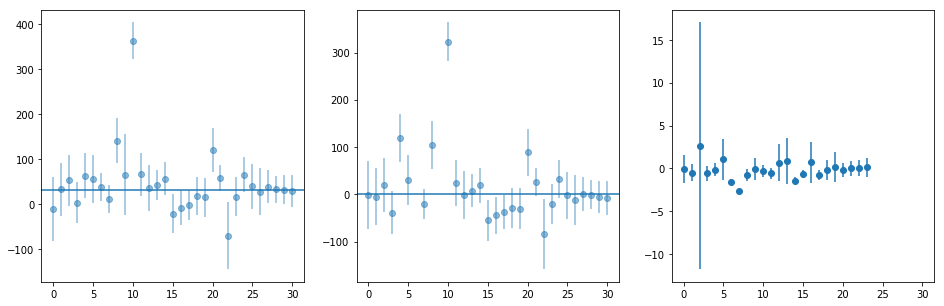

id = 43158593054180069
-1.8307965810084361 1.0678552247262643
-1.8307965810084361


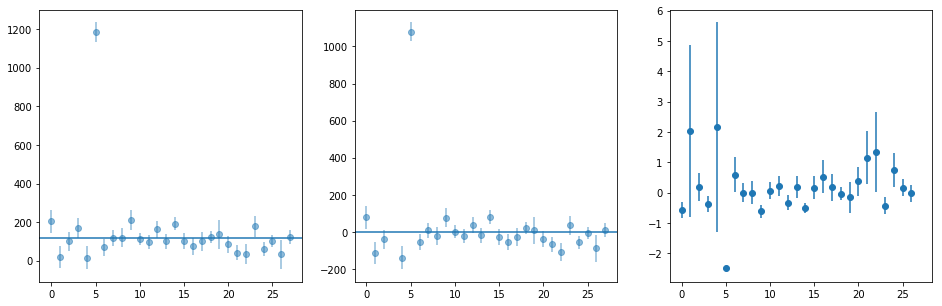

id = 43158593054180191
-1.8878168557235984 0.5091849641917597
-1.8878168557235981


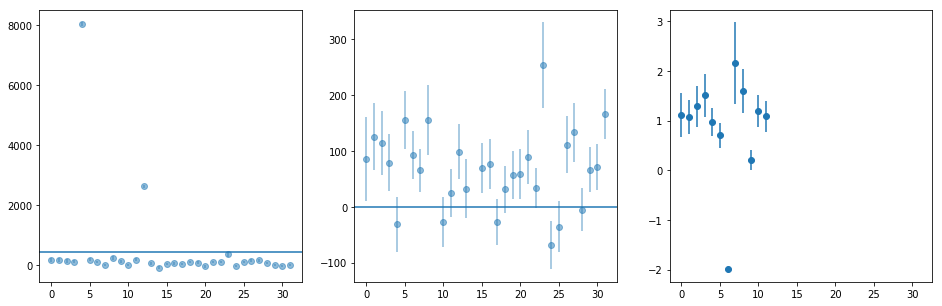

In [257]:
new_flux_meas = np.zeros((len(measurements), psf.getComponentCount()))
new_flux_err = np.zeros((len(measurements), psf.getComponentCount()))
for mm, m in enumerate(measurements.index[:200]):
    flux_measurements = []
    flux_measurements_diff = []
    visits = []
    visits_diff = []
    flux_errs = []
    flux_errs_diff = []
    if (weightedMagAvgs[mm] + 27) > 26: continue
    print('id =', measurements['id'][m])
    print(weightedMagAvgs[mm], calexp_mag_std[mm])
    point = geom.Point2D(measurements['slot_Centroid_x'][m], measurements['slot_Centroid_y'][m])
    for i in range(psf.getComponentCount()):
        calexpPoint = psf.getWcs(i).skyToPixel(coaddWcs_diffim.pixelToSky(point))
        if psf.getValidPolygon(i).contains(calexpPoint):
            ccd = int(inputs.ccds['ccd'][i])
            visit = int(inputs.ccds['visit'][i])
            calexp = butler.get('forced_src', tract=9813, filter='HSC-I', ccd=ccd, visit=visit)
            diffim = butler_diffim.get('forced_diaSrc', tract=9813, filter='HSC-I', ccd=ccd, visit=visit)
            match = calexp[(abs(calexp['coord_ra'] - measurements['coord_ra'][m]) < 0.000005)
                          & (abs(calexp['coord_dec'] - measurements['coord_dec'][m]) < 0.000005)]
            match_diff = diffim[(abs(diffim['coord_ra'] - measurements['coord_ra'][m]) < 0.000005)
                          & (abs(diffim['coord_dec'] - measurements['coord_dec'][m]) < 0.000005)]
            if len(match) != 0:
                match = match[0]
                new_flux_meas[mm, i] = match['base_PsfFlux_instFlux'] * match['base_LocalPhotoCalib']
                new_flux_err[mm, i] = match['base_PsfFlux_instFluxErr'] * match['base_LocalPhotoCalib']
                flux_measurements.append(match['base_PsfFlux_instFlux'] * match['base_LocalPhotoCalib'])
                flux_errs.append(match['base_PsfFlux_instFluxErr'] * match['base_LocalPhotoCalib'])
                visits.append(visit)
            if len(match_diff) != 0: 
                match_diff = match_diff[0]
                flux_measurements_diff.append(match_diff['base_PsfFlux_instFlux'] * match_diff['base_LocalPhotoCalib'])
                flux_errs_diff.append(match_diff['base_PsfFlux_instFluxErr'] * match_diff['base_LocalPhotoCalib'])
                visits_diff.append(visit)
    fig, subs = plt.subplots(1,3, figsize=(16, 5), sharex=True)
    subs[0].errorbar(np.arange(len(visits)), flux_measurements, yerr=flux_errs, marker='o', linestyle='None', alpha=0.5)
    subs[1].errorbar(np.arange(len(visits_diff)), flux_measurements_diff, yerr=flux_errs_diff, marker='o', linestyle='None', alpha=0.5)
    #subs[0].scatter(np.arange(len(visits), calexp_flux[]))
    subs[0].axhline(measurements['base_PsfFlux_instFlux'][m] * c.getCalibrationMean())
    subs[1].axhline(0)
    pmag = mags[mm][mags[mm] != 0]
    print(np.average(pmag, weights=magWeights[mm][mags[mm] != 0]))
    subs[2].errorbar(np.arange(len(pmag)), pmag, yerr=magWeights[mm][mags[mm] != 0]**-0.5, marker='o', linestyle='None')
    plt.show()
  

### What is the range of blendedness values?

(array([  0.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,   1.,   2.,   2.,
          3.,   5.,   8.,  11.,  20.,  29.,  48.,  65.,  93., 141., 152.,
        162., 129.,  96.,   6.]),
 array([-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
        -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
          1]),
 <a list of 26 Patch objects>)

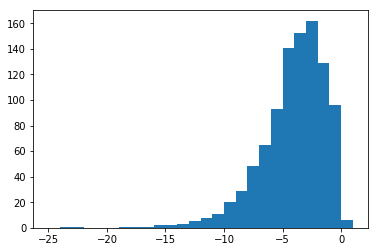

In [120]:
plt.hist(np.log(refCatalog['base_Blendedness_abs']), bins=np.arange(-25,2))

### What is the range of extendedness values?

/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/software/lsstsw/stack_20200220/python/miniconda3-4.7.12/envs/lsst-scipipe/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 171.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1067.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

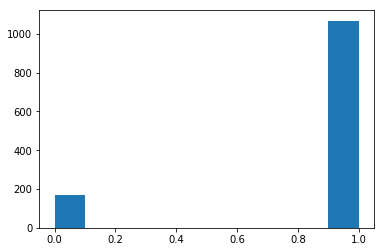

In [241]:
plt.hist(refCatalog['base_ClassificationExtendedness_value'])

In [226]:
butler_objTable = Butler('/datasets/hsc/repo/rerun/RC/w_2020_03/DM-23121_obj/')

In [227]:
objTable = butler_objTable.get('objectTable_tract', tract=9813)